In [18]:
options(warn=-1)
library(ggplot2)
library(tidydata)
library(tidydata)
library(ggextra)
set.seed(6203)

ERROR: Error in library(tidydata): there is no package called ‘tidydata’


## Team Members

* Aaditya Vinnakota (Aaditya316) 
* Bao Vo (baovo022293) 
* Frank Corrao (fcorrao) 
* Michael Obin (Obin_michael)
* Nicholas Coyle (nscoyle) 

## Project Overview

### Goals

The goal of our analysis is to identify stock attributes and performance trends which are indicative of resilience during economic downturns. To do so, we leverage data for securities in the S&P 500 during several ‘down markets’ - identifying the stocks which outperform the market and analyzing the traits they have in common (e.g. industry, company size, etc). 

### Approach 

The metric we use to identify outperformance is Jensens Alpha.  We run a standard Jensen's Alpha regression:





For each period, we identify the top 30% of positive alpha stocks and code them as outperformers.  This output beceomes the target of a 
logistic regression to identify features predective of that good performance:




Variables that survive backwards-selection and are statistically significant will be deemed features that predict outperformance.


### Initial Hypothesis / Literature Review

Through this research, we have formed several hypotheses about which types of companies might outperform in recession. We have identified two papers, (Woszczyk 2019) and (Ozkan 2009), which explore investment strategy during economic downturns. Researchers suggest that ‘vice stocks’ tend to outperform as folks resort to ‘bad habits’ (e.g. drinking, smoking, gambling) during times of unemployment Sources 2 (Ozkan 2009).
They also find that healthcare companies are resilient, as demand can be relatively inelastic for medical care (Woszczyk 2019).

## Overview of Data

Most of the data for this analysis was from sources that were relatively clean. The key componets we needed for the analysis:

* For identifying outperformers
  * Data to identify recessionary periods
  * Stock and index returns
  * Index components
* For identiying attributes that predict outperformance
  * Stock specific attributes (industry, common factor exposures, etc)
  * Macroeconomic factors

### Identifying recessions

We observice market performance during several recession periods in the United States as idenfitied by the [Federal Reserve GDP based recession indicator](https://fred.stlouisfed.org/series/JHDUSRGDPBR).

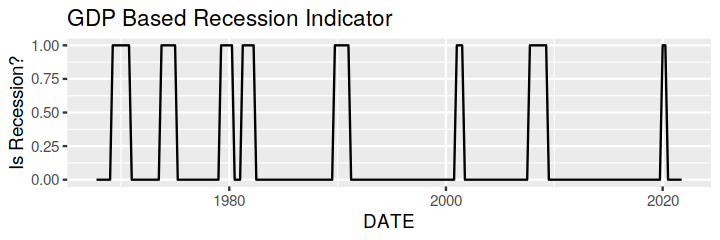

In [23]:
options(repr.plot.width=6, repr.plot.height=2)
is_recession <- read.csv('../Data/JHDUSRGDPBR.csv')
is_recession$DATE <- as.Date(is_recession$DATE)
ggplot(is_recession, aes(x=DATE,y=JHDUSRGDPBR)) + geom_line() + ylab('Is Recession?') + ggtitle("GDP Based Recession Indicator") 

Due to limitations in access to historical data, we evalute performance to the three most recent recessions:

* January 2001 - October 2001
* December 2007 - June 2009
* January 2020 - September 2020

### Stock returns

Corporate action adjusted stock and index prices were pulled from yahoo via the tidyquant R package. From this data, monthly returns were calculated.  S&P500 Index components were idenfied from publicly available sources.

### Stock specific attributes and Macroeconomic factors

Stock sectors were pulled from Yahoo via tidyquant.  Macroeconomic factors such as interest rate and unemployment rate were pulled from Federal Reserve Bank of St. Louis (FRED), also via tidyquant. 

## Overview of Modeling

### Identifying outperformers

Identifying companies that do well in absolute return space during the peak to through phase of a business cycle is difficult. It may be the case that the vast majority of stocks are losers, simply due to exposure to market beta. Instead, we focus on identifying those companies that outperform the market, which could easily form the basis of a market neutral strategy. The metric we use to identify outperformance is Jensens Alpha. We run a standard Jensen's Alpha regression:


We run this regression for S&P500 stocks for each recession period available to us, with the S&P500 return in placeof the market return.  Fitted alpha values are mapped to class labels {outpeformer/Not outperformer} by finding the cutoff for the top 30% percentile alpha in each period, marking everything above that cutoff that is positive as an Outperformer.  A threshold above the median was selected through exploratory analysis showing that this cutoff gave consistently positive returns of > 2%, which should be enough to cover implentation costs and buffer against regression standard errror. With these labels now in place, we can now use our outperformers in a classifier.  

### Identifying predictors of outperformance

With our coded outperformers over multiple recessionary periods in hand, we have a target to train a classifer on. We chose a logistic regression for its relatively good performance and interpertability.

There is a long list of possible factors that could predict market returns, but our imagination is limted by our data as we could not secure access to a professional quality source of equities data.  Some of the features we were able to consider are:


* Trailing 12 month returns 
* Trailing 12 month volatility
* Company sector
* Average unemployment rate in the period
* Interest rates in the period

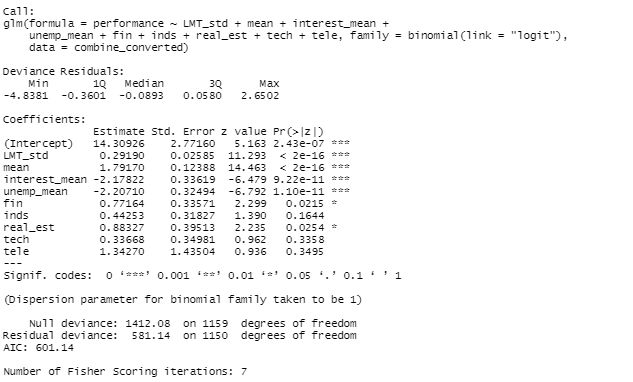

In [33]:
library(IRdisplay)
display_png(file="../Visualizations/regression_1.png", height=600, width=400)
#![image.PONWP1.png](../Visualizations/regression_1.png)

We perform backwards-selection to remove some insignicant variables to get a final regression output

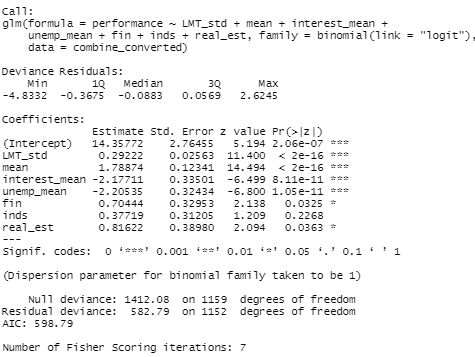

In [34]:
library(IRdisplay)
display_png(file="../Visualizations/regression_2.png", height=600, width=400)

### Findings

Six variables are significant at the 95% confidence interval:


* Trailing Company Returns 
* Trailing Company Volatility
* Is Finance Sector
* Is Real Estate
* Average interest rate
* average unemployment rate

Strong performance in the year leading up to the recessionary period was indicative of outperformance, as is stock volatility.  The finance an real estate sectors show outperformance during recessions.  As unemployment and interest rates rise, peformance decreases.  

### Challenges

There are several key challenges that must be overcome to make these results more robust and realistic:

1.  Limited Historical Data: as our access to historical S&P 500 data was limited, we could only evaluate three
recession periods. Further, within those recession periods, there were some individual stocks for which data was
unavailable (e.g. for the 2001 recession period, we only had data for 340 stocks in the S&P 500). We did our best
to mitigate this by using code to track the changes in the S&P 500 listed in wikipedia
2.  Limited Operational Performance Data: operational performance data (e.g. market cap, operating income,
profit margin) may have been useful in predicting resilience during downturns. However, access to this data
required significant investment
3.  Non-stationarity: long periods of time between recessions means the patterns we find in our training data
may simply no longer exist due to naturally changing market and macroeconomic dynamics
             

## Future Direction

There are a number possible ways to continue this work, the most important being to acquire a longer history of data, and more stock specific data, like common equity factor exposures, to regress against.  Another important future direction would be to include the use of non-linear classifiers, or non-linear feature transformation as some patterns may be complicated. For instance, though we found that trailing performance/momentum is predictive of outperformance during a recession, perhaps the biggest outperformers could perform poorly if they are part of a bubble that has formed. Lastly, should a recession be upon us, it will be important to use that to validate our results.

## Sources



1.  Woszczyk K, 2019, ‘Do mutual funds invest in recession-proof industries prior to
crisis?’, MSc thesis, Erasmus University Rotterdam, Rotterdam [(link)](https://thesis.eur.nl/pub/48135/Thesis-final-K-Woszczyk-25.07.pdf)
1.  Ozkan F C, Xiong Y, 2009, ‘Wise Investing: Analysis of the recession-proof sin
stocks’, MBA thesis, Simon Fraser University, British Columbia [(link)](http://summit.sfu.ca/item/709)
1.  Tidyquant, source of stock data (via Yahoo) and macroeconomic times series (via
Fred) [(link)](https://cran.r-project.org/web/packages/tidyquant/vignettes/TQ05-performance-analysis-with-tidyquant.html)
1.  Kaggle, guidance for performing S&P 500 Analysis in R [(link)](https://www.kaggle.com/code/paytonfisher/s-p-500-analysis-using-r/notebook)
1.  Schwab, ‘Macro-economic factors of fundamental analysis’ [(link)](https://www.cnbc.com/advertorial/2018/06/11/macro-economic-factors-of-fundamental-analysis.html)
1.  Stijn Claessens, M. Ayhan Kose, and Marco E. Terrones, 2008, ‘What Happens During Recessions, Crunches and Busts?’ [(link)](https://www.imf.org/external/pubs/ft/wp/2008/wp08274.pdf)
1.  U.S. Bureau of Labor Statistics, Unemployment Rate [UNRATE], retrieved from FRED, Federal Reserve Bank of St. Louis;
https://fred.stlouisfed.org/series/UNRATE, July 18, 2022 [(link)](https://fred.stlouisfed.org/series/UNRATE)
1.  Board of Governors of the Federal Reserve System (US), Federal Funds Effective Rate [FEDFUNDS], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/FEDFUNDS, July 18, 2022 [(link)](https://fred.stlouisfed.org/series/FEDFUNDS)
1.  Hamilton, James, Dates of U.S. recessions as inferred by GDP-based recession indicator [JHDUSRGDPBR], retrieved from FRED, Federal Reserve
Bank of St. Louis; https://fred.stlouisfed.org/series/JHDUSRGDPBR, July 18, 2022 [(link)](https://fred.stlouisfed.org/series/JHDUSRGDPBR)

## Code